# GCM parameterizations, skill metrics, and other sources of uncertainity

In the last notebook we provided a very quick overview of the problem we run into when trying to simulate a real system (e.g. the atmosphere) on a computer using a General Circulation Model (GCM), even when the exact equations to be solved are known in principle. The problem of limited computational resources translates into an inability to resolve all scales of motion in a GCM, and the unresolved scales need to be parameterized. 

The objective of this notebook is to introduce some more of the key aspects of parameterizations in GCMs, illustrating the deterministic vs stochastic approaches, the interplay with numerical errors, and how to measure the skill of a parameterization. We also provide a comprehensive discussion of the different sources of errors that are present in GCMs.

## The need for GCM parameterizations

Let's first quickly review some concepts from the last notebook, using a slightly modified framing that might benefit some readers. 
We will assume from now on that the readers are familiar  with the {cite}`Lorenz1995` two-time scale model and its numerical implementation in the `L96_model` module, which was discussed in {doc}`L96-two-scale-description`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot

Here, `L96` serves as the **"real world"** or two time-scale model, whereas `L96_eq1_xdot` represents the **beginning of rhs of X tendency** or the tendency in the single time-scale model.

In [2]:
# Setting the seed gives us reproducible results
np.random.seed(13)

# Create a "real world" with K = 8 and J = 32
W = L96(8, 32, F=18)

Since we start the model with a random initial condition, there is no reason to expect that these initial conditions are an actual solution to the model. These arbitrary states can result in initial shocks to the system, which will are unrealistic features but get dissipated after some time.
So we *run the "real world" for 3 days in order to forget the initial conditons*, and settle into a state that is an actual solution to the model.

In [3]:
# `store=True` saves the final state as an initial condition for the next run.
W.run(0.05, 3.0, store=True);

From here on we can use `W.X` as perfect initial conditions for a model and sample the "real world" using `W.run(dt, T)`.

**How to think about the real world vs models:**

Let's call $Z(t)$ the trajectory of the full complexity physical system (say planet earth). Because in practice, for computational or observational reasons, we cannot afford describing and predicting $Z(t)$, we will only focus on a projection of $Z(t)$ in some lower dimension space. Let's call this reduced dimension state $X(t)$.

In our L96 toy model (analog to the real world),  $Z(t)=(X(t),Y(t))$ is the full complexity physical system, while $X(t)$ is the lower dimension reduction (single time-scale models is analog to the GCM). In real world situations or more complex models (e.g. actual atmosphere or ocean models), the lower dimension representation of the real system may be thought of as a coarse-grained or a subsampled description of the full-scale system.

Now, a GCM is simply a numerical machine which intends to predict the trajectory $X(t)$ from knowledge of $X(t=0)$ only. A GCM is generally built from first principle physical laws, by discretizing partial differential equations.

In what follows, we therefore assume that we know a fraction of the terms that govern the evolution of $X$. We also assume that we do not know what governs the evolution of $Y$ nor how $Y$ may affect $X$.

**GCM without parameterization**

In [4]:
def GCM_no_parameterization(X0, F, dt, nt):
    """GCM without parameterization

    Args:
        X0: initial conditions
        dt: time increment
        nt: number of forward steps to take
    """
    time, hist, X = (
        dt * np.arange(nt + 1),
        np.zeros((nt + 1, len(X0))) * np.nan,
        X0.copy(),
    )
    hist[0] = X

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F))
        hist[n + 1], time[n + 1] = X, dt * (n + 1)
    return hist, time

This GCM is unstable due to Euler forward time stepping scheme, so we don't integrate it for too long and compare it to the real world with the same time interval as `dt` used by the model.

In [5]:
F, dt, T = 18, 0.01, 3.0
X, t = GCM_no_parameterization(W.X, F, dt, int(T / dt))

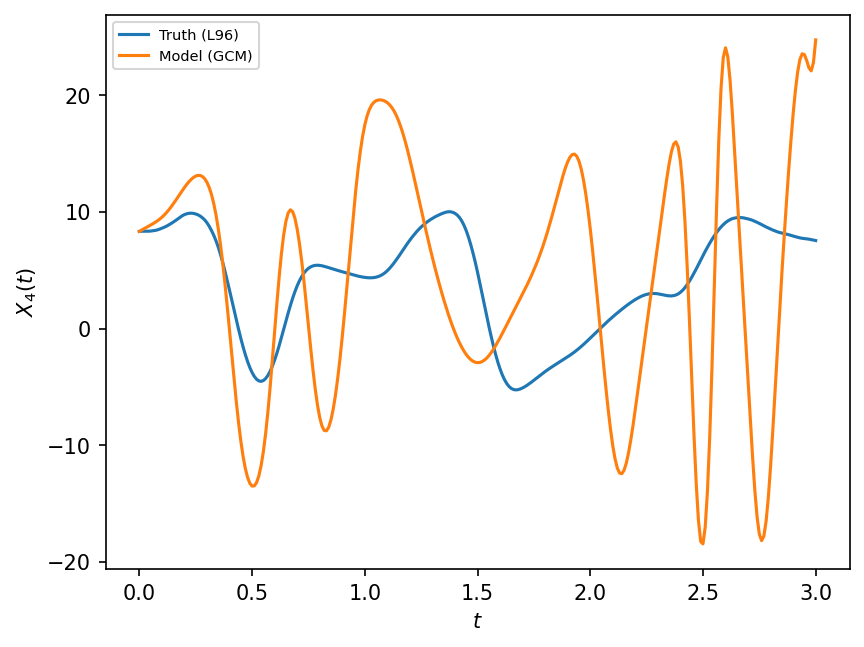

In [6]:
# Compare with the real world
X_true, _, _ = W.run(dt, T)

plt.figure(dpi=150)
plt.plot(t, X_true[:, 4], label="Truth (L96)")
plt.plot(t, X[:, 4], label="Model (GCM)")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

There are several reasons why the above model (i.e. single time-scale model) differs from truth (i.e. L96 two time-scale model), which will be discussed below in {ref}`other-sources-affect-gcm`. One of these reasons is missing physics.

One way, discussed in the previous notebook, to reduce the differences between the Model and the Truth, is to add a *parameterization*: an extra term to the rhs of the Model evolution operator in order to reduce the Model error as compared to the Truth. It may account for missing processes that are present in the truth, but are not included in the reduced model. The missing processed may be a result of unresolved scales (sub-grid processes) or due to physical processes that could not be encoded into the full equations.
*Parameterizations* are also commonly refered to as *closures*, in particular when they encode explicit physical assumptions on how non-represented variables (e.g. $Y$) impact represented variables (e.g. $X$). 

Parameterizations usually involve free parameters that need to be adjusted. The form of the parameterization may be dictated by physical laws, but generally it is unknown as well.

**GCM with parameterization**

In [7]:
# Here we introduce a class to solve for the one time-scale problem,
# which can take arbitrary parameterizations and time-stepping schemes as input.
class GCM:
    """GCM with parameterization in rhs of equation for tendency"""

    def __init__(self, F, parameterization, time_stepping=EulerFwd):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) - self.parameterization(param, X)

    def __call__(self, X0, dt, nt, param=[0]):
        """
        Args:
            X0: initial conditions
            dt: time increment
            nt: number of forward steps to take
            param: parameters of our closure
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

As a first step, we illustrate introducing a polynomial parameterization to GCM and then compare the model to the true trajectories obtained from the real world with the same time interval as `dt` used by the model. This is the same as what was done in the previous notebook, but is shown again for completeness.

In [8]:
naive_parameterization = lambda param, X: np.polyval(param, X)
F, dt, T = 18, 0.01, 5.0
gcm = GCM(F, naive_parameterization)
X, t = gcm(W.X, dt, int(T / dt), param=[0.85439536, 0.75218026])
# we use the parameters for the linear polynomial parameterization that were learnt in the last notebook.

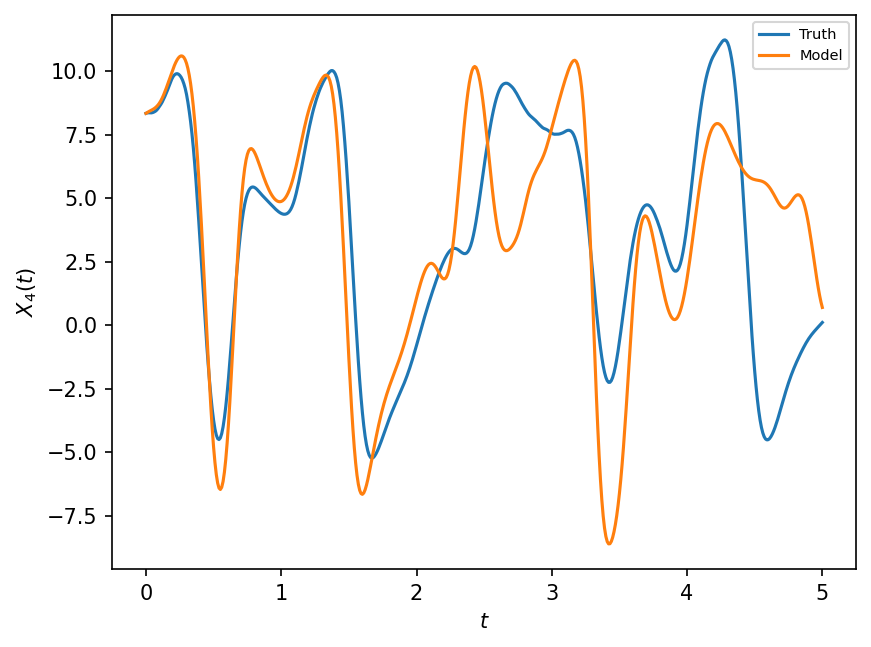

In [9]:
# Compare with the real world
X_true, _, _ = W.run(dt, T)

plt.figure(dpi=150)
plt.plot(t, X_true[:, 4], label="Truth")
plt.plot(t, X[:, 4], label="Model")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

While the GCM with parameterization is better than the GCM without parameterization, it is still not very good at reproducing the true evolution of the full system. It also remains to find the most appropriate coefficients of the polynomial parameterization to make the Model as close as possible to the Truth.

In summary, the parameterization problem boils down to defining the functional form and finding the best parameters in order to minimize the distance between the true trajectory and the model trajectory.
**With M2LINES, we are approaching this problem as a Machine Learning problem. We want to learn parameterizations from objective measures of their skills through an optimization procedure.**
But we are not only interested in learning the parameters of existing functional forms. More generally, we would like to learn the functional forms too.   

## Should parameterizations  be deterministic or stochastic ? 

The `naive_parameterization` above has no particular physical nor mathematical justification. Most importantly, it relies on a very strong assumption, that the time rate of change of $X$ at time $t$ is a function of $X(t)$. This assumption implies that the future evolution of the reduced dimension system $X(t)$ is *deterministically* related to the initial reduced dimension state $X(0)$.   

But this is not a good assumption because the two identical reduced dimension states ($X$, macro-state) can be associated with very different fine scale states ($Y$, micro-state). This can also be seen visually by considering the [plot](sub-grid-hist-label) in the previous notebook, which shows that the for each value of $X$ there is a range of possible values for the sub-grid effects.
Given the non-linearity of the evolution equation for $Z$, the two large scale trajectories will diverge at some point due to these small differences in the un-observed states. Let's illustrate that with L96 alone. 

In [10]:
# Randomising the initial Ys
np.random.seed(13)

# Duplicating L96 to create perturbed versions that include random perturbations in Y
Wp1 = W.copy()
Yp1 = W.Y.std() * np.random.rand(Wp1.Y.size)
Wp1.set_state(W.X, Yp1)

Wp2 = W.copy()
Yp2 = W.Y + 0.0001 * np.random.rand(Wp2.Y.size)
Wp2.set_state(W.X, Yp2)

L96: K=8 J=32 F=18 h=1 b=10 c=10 dt=0.001

In [11]:
# Running L96 and perturbed versions to compare results
X_true, _, _ = W.run(dt, T)
X_pert1, _, _ = Wp1.run(dt, T)
X_pert2, _, _ = Wp2.run(dt, T)

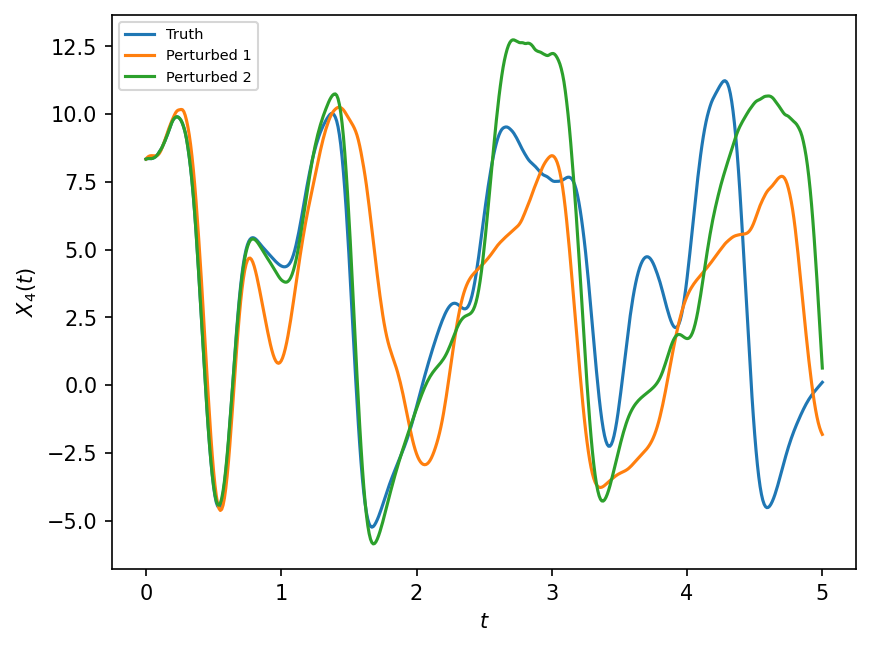

In [12]:
plt.figure(dpi=150)
plt.plot(t, X_true[:, 4], label="Truth")
plt.plot(t, X_pert1[:, 4], label="Perturbed 1")
plt.plot(t, X_pert2[:, 4], label="Perturbed 2")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

So even very small uncertainties in the micro-state ($Y$) of L96 can lead to large scale changes (i.e. of the variable $X$) over short time.

In a Model that does not know anything about micro-state $Y$, it is possible to introduce this uncertainty through a stochastic form in the parameterization.


In addition, with this illustration, we also highlight that there is a horizon after which pointwise comparisons of the model with the truth are meaningless, hence there is some needed discussion on how to measure the skill of a parameterization.

## How to measure parameterization skill ? 

We would like to build our closures by systematically measuring their skills, so that we can compare different fomulations using these "skill scores". 

Since we are interested in matching the evolution of the "real world" using a GCM, we define skill scores that measure the distance between the evolution of the true state $X_{true}$ and the simulated state $X_{gcm}$. 

In [13]:
# Defining our GCM
F, dt, T = 18, 0.005, 100.0
gcm = GCM(F, naive_parameterization)

# Evaluare the GCMs
X_gcm, t = gcm(W.X, dt, int(T / dt), param=[0.85439536, 0.75218026])
X_gcm_no_param, _ = gcm(W.X, dt, int(T / dt), param=[0, 0])

# Evaluate the true state
X_true, _, _ = W.run(dt, T)

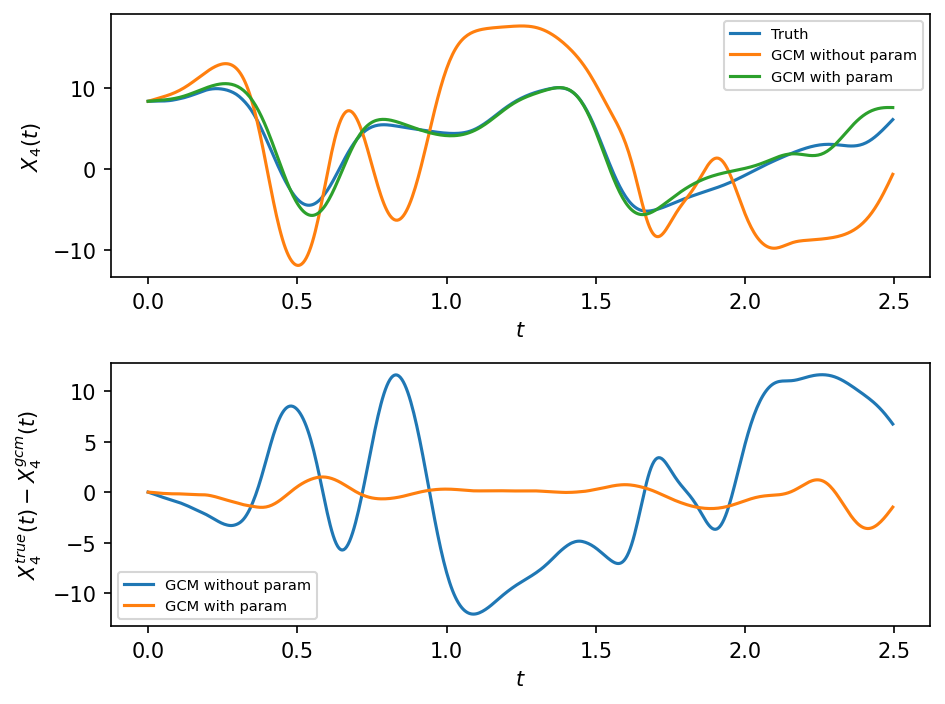

In [14]:
# Plotting the results
plt.figure(dpi=150)

plt.subplot(211)
plt.plot(t[:500], X_true[:500, 4], label="Truth")
plt.plot(t[:500], X_gcm_no_param[:500, 4], label="GCM without param")
plt.plot(t[:500], X_gcm[:500, 4], label="GCM with param")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7)

plt.subplot(212)
plt.plot(
    t[:500], (X_true[:500, 4] - X_gcm_no_param[:500, 4]), label="GCM without param"
)
plt.plot(t[:500], (X_true[:500, 4] - X_gcm[:500, 4]), label="GCM with param")
plt.xlabel("$t$")
plt.ylabel("$X_4^{true}(t) - X_4^{gcm}(t)$")
plt.legend(fontsize=7)

plt.tight_layout()

**Error metric based on model evolution**:

Clearly, the absolute error between the true and gcm trajectory grows with time, and we would like measure how the error cumulates over time.
A simple error metric is the point-wise root mean square error, which is averaged over time:

\begin{equation}
E (t) = \frac{1}{t} \int_0^t |X_{true}(t) - X_{gcm}(t)| dt
\end{equation}

This can be computed for each $X_k$ separately, or averaged over all $k$.

In [15]:
def pointwise_msq(X1, X2, t=t, L=1.0):
    """Pointwise mean square error computed over some window t < L."""
    D = (X1 - X2)[np.where(t < L)]
    return np.sqrt(D**2).mean(axis=0)

In [16]:
measure_distance = lambda l: pointwise_msq(X_true, X_gcm, L=l)
measure_distance_no_param = lambda l: pointwise_msq(X_true, X_gcm_no_param, L=l)

# Since t is sorted, t[0] will give an empty distance in the `pointwise_msq` function.
# So we calculate the mean square error starting from the 2nd element i.e. t[1]
dist = np.array([measure_distance(l) for l in t[1:]])
dist_no_param = np.array([measure_distance_no_param(l) for l in t[1:]])

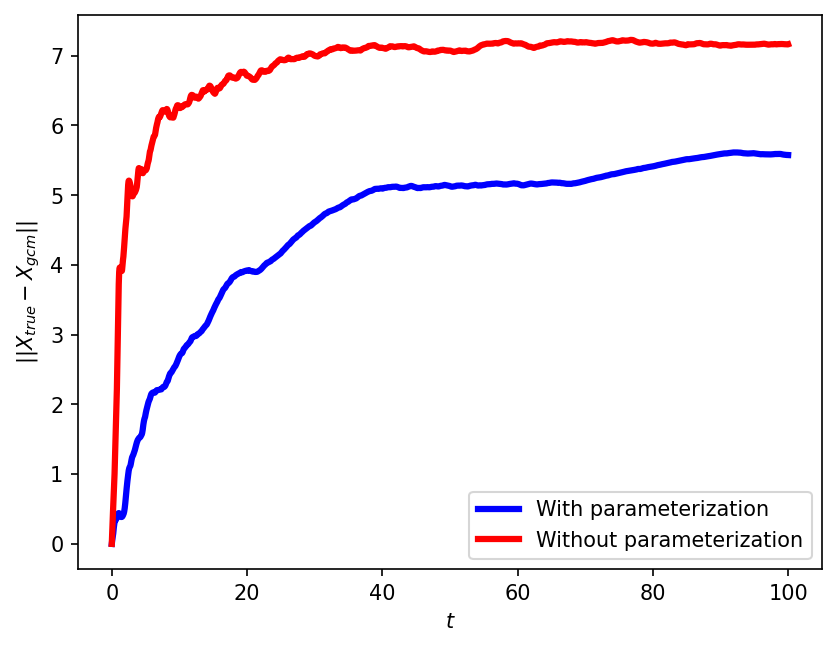

In [17]:
# Plotting how this distance grows with the length of the window
# for all the components of X
plt.figure(dpi=150)
# plt.plot(t[1:], dist)
plt.plot(t[1:], np.mean(dist, 1), linewidth=3, color="b", label="With parameterization")
plt.plot(
    t[1:],
    np.mean(dist_no_param, 1),
    linewidth=3,
    color="r",
    label="Without parameterization",
)

plt.xlabel("$t$")
plt.legend()
plt.ylabel("$||X_{true}-X_{gcm}||$");

The error grows with time, but saturates to some a constant after the truth and GCM have gotten completely decorrelated. This constant is equal to the sum of the variance of the truth and GCM states. Also, as expected, the error grows much more rapidly without a parameterization, showing that adding the parameterization has resulted in a quantitative improvement in the solution.

**Climatology based error metric:**

Knowing from the above discussion that the system is not predictable after some time, we may as well have decided to measure how well the model captures the mean state. With this we expect to measure the "climate" of the system instead of the "weather". 

\begin{equation}
E_{clim}  = | \overline{X_{true}}  - \overline{X_{gcm}}|
\end{equation}

where the $\overline{(.)}$ is some suitably defined average that may be variable in time (like a seasonal climatology). 

This metric will likely converge to some non-trivial values which are indicative of how well our model captures the "climate" of the system, and the difference indicating the bias in the model.

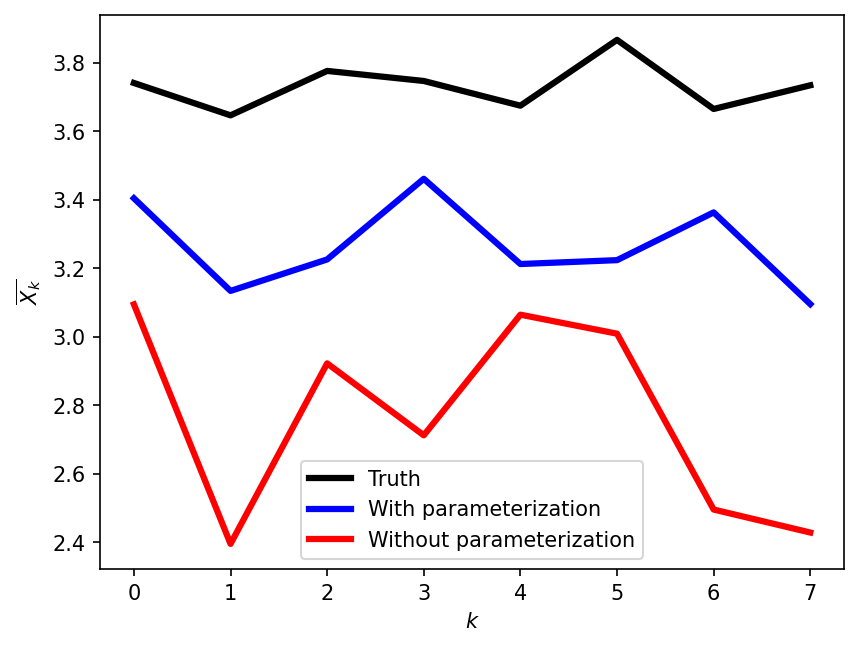

In [19]:
plt.figure(dpi=150)

plt.plot(np.mean(X_true, 0), linewidth=3, color="k", label="Truth")
plt.plot(np.mean(X_gcm, 0), linewidth=3, color="b", label="With parameterization")
plt.plot(
    np.mean(X_gcm_no_param, 0), linewidth=3, color="r", label="Without parameterization"
)

plt.xlabel("$k$")
plt.legend()
plt.ylabel("$\overline{X_{k}}$");

As seen in the above figure, the long term mean state of the true solution is very different from the solution without the parameterization. The solution with the parameterization is closer to the truth.

Below, we check how this metric (defined as the root mean square error) depends on the averaging time.

In [ ]:
from numba import jit

In [ ]:
@jit
def dist_mean(X1, X2, L=1.0):
    """Mean state metric."""
    _X1 = X1[np.where(t < L)]
    _X2 = X2[np.where(t < L)]
    return np.sqrt((_X1.mean(axis=0) - _X2.mean(axis=0)) ** 2)

In [ ]:
measure_dist = lambda l: dist_mean(X_true, X_gcm, L=l)
measure_dist_no_param = lambda l: dist_mean(X_true, X_gcm_no_param, L=l)

dist = np.array([measure_dist(l) for l in t[1:]])
dist_no_param = np.array([measure_dist_no_param(l) for l in t[1:]])

In [ ]:
# Plotting how this distance grows with the length of the window
# averaged over all the components of X
plt.figure(dpi=150)
plt.plot(t[1:], np.mean(dist, 1), label="With Param")
plt.plot(t[1:], np.mean(dist_no_param, 1), label="Without Param")
plt.xlabel("$t$")
plt.ylabel("$||\overline{X_{true}}-\overline{X_{gcm}}||$")
plt.legend()

The RMSE difference in the mean state (climatology) is larger when the there is no parameterization. At long time, this metric stabalizes, as the time average starts to become more representative of the long time state of the system.  

**Tendency based error metric**:

It is also very common to formulate closures based on databases of initial tendencies.  In the Large Eddy Simulation  community, this is sometimes refered to as *a priori* skill, because you don't need to run the full model to compute it.

This is the sort of game that several of us have been playing, trying for instance to estimate subgrid fluxes from knowledge of the large scale quantities  $$ \nabla\cdot \mathbf{s} =   \nabla\cdot\big(\overline{\mathbf{u}\,\Phi} - \overline{\mathbf{u}}\,\overline{\Phi}\big) \simeq f(\overline{\mathbf{u}},\overline{\Phi})$$

*Note that this is not exactly the same problem as the `a priori` LES problem, because of the interplay with time-discretization. Let's neglect that for the moment.*

In [ ]:
def norm_initial_tendency(X1, X2):
    T1 = X1[1, :] - X1[0, :]
    T2 = X2[1, :] - X2[0, :]
    return np.sqrt((T1 - T2) ** 2).mean(axis=0)

Because this metric is cheap to evaluate, as we do not need to integrate the GCM more than 1 time-step, we can start a sensitivity analysis in order to identify good optimal parameters for the specific formulation `naive_parameterization`

In [ ]:
F, dt = 18, 0.01

# Let's define again the true state
# But only run for 1 time step
X_true, _, _ = W.run(dt, dt)

# and an ensemble of trajectories
gcm = GCM(F, naive_parameterization)

n = 100

_p1 = np.linspace(-20, 20, n + 1)
_p2 = np.linspace(-20, 20, n + 1)
xp1, yp2 = np.meshgrid(_p1, _p2)

score = np.zeros((n + 1, n + 1))

for i, p1 in enumerate(_p1):
    for j, p2 in enumerate(_p2):
        X_gcm, t = gcm(W.X, dt, 1, param=[p1, p2])  # run gcm for 1 time step
        score[i, j] = norm_initial_tendency(X_true, X_gcm)

In [ ]:
plt.figure(dpi=150)
plt.contourf(xp1, yp2, score)
plt.colorbar()
plt.xlabel("$p_2$")
plt.ylabel("$p_1$")
plt.title("Score");

From this analysis, we see that the optimisation problem is probably well posed as the cost function appears pretty smooth. One can also see that the parameter $p_1$ is more important than $p_2$.  

(other-sources-affect-gcm)=
## Sources of model error

Missing physics is not the only source of error in GCMs, and many other factors can contribute to the GCM state diverging from the real world. 
Here, we consider the following five sources of error:

1. Missing physics: which is modeled with a GCM without parameterization that corresponds to the one time-scale Lorenz-96 system without any the coupling term.
2. Poorly parameterized unresolved physics: which is studied by considering a first-order and third-order polynomial approximations of the coupling terms:
    \begin{equation*}
    P_4 \rightarrow P_1
    \end{equation*}
3. Unknown forcing: which is modeled by adding an error to the forcing term:
    \begin{equation*}
    F \rightarrow F + error
    \end{equation*}
4. Numerical approximation: which is studied by increasing the time-step:
    \begin{equation*}
    \Delta t \rightarrow 10 \Delta t
    \end{equation*}
5. Initialization error: which is modeled by adding an error to the initial condition:
    \begin{equation*}
    X(t=0) \rightarrow X(t=0) + error
    \end{equation*}
  
The first two sources have already been discussed in some detail previously, and included here to contrast against other error sources.

The next code estimates these sources of error and the figure shows their relative contributions. For reference, we also plot the error of the GCM using {cite}`Wilks2005` polynomial coupling term and without any of the sources of error listed above. All errors are evaluated by comparing the GCMs to the "truth" model goverened by the full two time-scale Lorenz-96 system.

In [ ]:
# Generic GCM parameters
F, dt, T = 18, 0.002, 40.0
X0 = W.X

# Remember the optimized parameters from previous notebook
p1 = [0.85439536, 0.75218026]
p4 = [
    0.000707,
    -0.0130,
    -0.0190,
    1.59,
    0.275,
]

# Sampling real world over a longer period of time
X_true, _, t = W.run(dt, T)

# GCM with different parameterizations
gcm = GCM(F, naive_parameterization)
X_no_param, t = gcm(W.X, dt, int(T / dt), param=[0])  # Missing physics
X_p1, _ = gcm(W.X, dt, int(T / dt), param=p1)  # Simpler but poorer parameterization
X_p4, _ = gcm(W.X, dt, int(T / dt), param=p4)  # More complex parameterization

# GCM with perturbed forcing
gcm_pert_F = GCM(F + 1.0, naive_parameterization)
X_frc, _ = gcm_pert_F(W.X, dt, int(T / dt), param=p4)  # Perturbed forcing

# GCM with perturbed IC
X_IC, _ = gcm(W.X + 0.5, dt, int(T / dt), param=p4)  # Perturbed IC

# GCM with changed dt
X_dt, t_dt = gcm(W.X, 5 * dt, int(T / (5 * dt)), param=p4)  # Larged dt

In [ ]:
plt.figure(dpi=150)

plt.plot(t, X_true[:, 4], label="Truth")
plt.plot(t, X_no_param[:, 4], label="GCM without param")
plt.plot(t, X_p1[:, 4], label="GCM with linear param")
plt.plot(t, X_p4[:, 4], label="GCM with 4th order param")
plt.plot(t, X_frc[:, 4], label="GCM with perturbed forcing")
plt.plot(t, X_IC[:, 4], label="GCM with pertured IC")
plt.plot(t_dt, X_dt[:, 4], label="GCM with increased dt")

plt.xlim([0, 4])
plt.legend()

plt.xlabel("$t$")
plt.ylabel("$X_{4}(t)$");

Clearly perturbing the gcm in different ways results in different solutions. Below we quantify these effects using the pointwise_msq metric that was defined earlier. We present the results as an average over all k. 

In [ ]:
def dist(X1, X2, time):
    measure_distance = lambda l: pointwise_msq(X1, X2, t=time, L=l)

    return np.mean(np.array([measure_distance(l) for l in time[1:]]), 1)

In [ ]:
dist_no_param = dist(X_true, X_no_param, t)
dist_p1 = dist(X_true, X_p1, t)
dist_p4 = dist(X_true, X_p4, t)
dist_frc = dist(X_true, X_frc, t)
dist_IC = dist(X_true, X_IC, t)
dist_dt = dist(X_true[::5], X_dt, t_dt)

In [ ]:
dist_dt = dist(X_true[::5, :], X_dt, t_dt)

In [ ]:
plt.figure(dpi=150)
plt.plot(t[1:], dist_no_param, label="GCM without param")
plt.plot(t[1:], dist_p1, label="GCM with linear param")
plt.plot(t[1:], dist_p4, label="GCM with 4th order param")
plt.plot(t[1:], dist_frc, label="GCM with perturbed forcing")
plt.plot(t[1:], dist_IC, label="GCM with pertured IC")
plt.plot(t_dt[1:], dist_dt, label="GCM with increased dt")

plt.legend()
plt.xlabel("$t$")
plt.ylabel("$E(t)$");

Under the perturbations considered above, the lack of missing physics contributes the most error to the GCM.  
This can be fixed by adding parameterizations, which have different contributions to error at different times. Specifically, the error grows more rapidly for the higher order parameterization relative to the linear parameterization, but saturates to smaller error at longer time. This might partly be because we optimized the parameters for the linear parameterization, but used parameter estimates for the higher order parameterization from the literature.  
The second largest error source is the numerical approximation (or changed dt), suggesting that we need to be careful about the design and choice of the numerical schemes.
The errors due to the forcing and initial condition reult in smaller errors, but will likely grow as the perturbations to these change. 


## Summary

In this chapter:
- We first reintroduced the GCM parameterization problem, discussing it in terms of limited observability of GCMs. 
- Then we discussed the need for stochastic parameterizations, which arises because of the possible differences in the unresolved or hidden states.
- Then we discussed how skill can be measured, and defined three different metrics. 
- Finally we discussed the different sources of error that may be presend in numerical GCMs. 

This chapter has made it clear that even models with some degree of tuning will diverge from the true solution, as there are multiple sources of errors. In the next chapter we discuss if and how GCMs and their parameterizations can be further tuned to enhance their range of predictability (which is known to not be in finite).